<a href="https://colab.research.google.com/github/Doriana245/Implementazione-BerTopic/blob/main/bert_python_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Progetto di analisi dati con BERT

In [1]:
# === STEP 1
# === Installazione dell'ambiente e delle librerie BERT

# Autorizzando Google Drive per la lettura file
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

# Installazione librerie necessarie BERT
!pip install bertopic
!pip install sentence-transformers
!pip install gensim

# Librerie python
import os
import re
import json
import ast
import pprint
import hdbscan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from collections import Counter
from bertopic import BERTopic
from umap import UMAP
from matplotlib.ticker import MaxNLocator

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 26.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [7]:
# === STEP 2
# === Configurazione del programma

folder_path = '/content/drive/My Drive/BERT/files'
year_from = 2004
year_to = 2024
print_debug = False

range_years = list(range(year_from, year_to + 1))

In [3]:
# === STEP 3
# === Esecuzione dell'allenamento con BERT

topic_model1 = None
topic_model2 = None

umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom'
)

def esegui_processamento_files(lines):
    global records

    i = 0
    while i < len(lines):
        if lines[i].strip() == '\n' or lines[i].strip() == '':
            i += 1
            continue

        # Identifico un documento dalla parola "http"
        # Lo usiamo come punto di aggancio
        if lines[i].strip().startswith("http"):
            diz = {}
            diz['title'] = lines[i-2].strip()
            diz['year'] = str(year)
            diz['abstract'] = lines[i+2].replace("ABSTRACT:", "").strip()
            keywords = lines[i+3].strip()

            if keywords.startswith("AUTHOR KEYWORDS:"):
                keys = keywords.replace("AUTHOR KEYWORDS:", "").strip()
                diz['keywords'] = [k.strip() for k in keys.split(";") if k.strip()]

            records.append(diz)
        i += 1
    return records


def esegui_allenamento_bert(records):
    global topic_model1, topic_model2, range_years, bert_arguments

    # 1) Memorizziamo una lista di titoli
    lista_titoli = []
    for documento in records:
        if int(documento['year']) not in range_years:
            continue
        lista_titoli.append(documento['title'])

    # 2) Memorizziamo una lista di abstract
    lista_abstract = []
    for documento in records:
        if int(documento['year']) not in range_years:
            continue
        lista_abstract.append(documento['abstract'])

    # 3) Pre-processamento: domain-specific stopword filtering e semantic noise reduction
    stopwords = [
        "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your",
        "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she",
        "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
        "theirs", "themselves", "what", "which", "who", "whom", "this", "that",
        "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
        "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
        "the", "and", "but", "if", "or", "because", "as", "until", "while", "of",
        "at", "by", "for", "with", "about", "against", "between", "into", "through",
        "during", "before", "after", "above", "below", "to", "from", "up", "down",
        "in", "out", "on", "off", "over", "under", "again", "further", "then", "once",
        "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
        "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only",
        "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just",
        "don", "should", "now", "-", "key", "use", "time", "task", "tasks", "forming",
        "emotion", "motion", "paper", "study", "studies", "result", "results", "tracking",
        "conclusion", "conclusions", "introduction", "discussion", "analysis",
        "approach", "method", "methods", "model", "models", "data", "dataset", "smart",
        "information", "work", "problem", "application", "applications", "case",
        "cases", "example", "examples", "related", "research", "literature", "review",
        "future", "state", "art", "experiment", "experiments", "experimental", "shown",
        "proposed", "provide", "provides", "using", "used", "based", "effect",
        "effects", "system", "systems", "design", "process", "processes", "production",
        "manufacturing", "engineering", "assembly", "industry", "industrial",
        "development", "performance", "control", "quality", "technique", "techniques",
        "technology", "technologies", "part", "parts", "application", "applications",
        "approach", "methods", "modeling", "planning", "tool", "tools", "machine",
        "machining", "cutting", "surface", "surfaces", "product", "flow", "material",
        "materials", "grind", "grinding", "cycle", "products", "life", "factories",
        "integration", "areal", "error", "errors", "calibration", "measuring", "developed",
        "instruments", "largescale", "dynamic", "reuse", "logitics", "micro", "supply",
        "cost", "costs", "methodology", "robustness", "scheduling", "multiobjective",
        "stiffness", "wear", "wears", "avoidance", "detection", "contact", "mass",
        "chatter", "uncertainty", "flexible", "precision", "companies", "milling",
        "properties", "learn", "learning", "maintenance", "modelling", "force", "human",
        "forces", "additive", "additives", "powder", "framework", "components", "logistic",
        "thermal", "bean", "decision", "collaborative", "environmental", "digital",
        "prediction", "complex", "global", "operation", "prognosis", "networks",
        "network", "support", "machines", "presents", "options", "year", "years", "customer"
        "today", "recent", "recently", "new", "novel", "future", "present", "paper",
        "conference", "journal", "cirp", "CIRP", "presented", "parameters", "parameter",
        "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013",
        "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "speed",
        "2024", "et", "al", "also", "one", "two", "three", "first", "second", "third", "edge",
        "within", "among", "etc", "else", "well", "known", "different", "various", "smart", "twin",
        "several", "many", "important", "high", "low", "large", "small", "negotiation", "improvement",
    ]

    for i in range(0, len(lista_titoli)):
        lista_titoli[i] = ' '.join([word for word in lista_titoli[i].split() if word.lower() not in stopwords])
        lista_abstract[i] = ' '.join([word for word in lista_abstract[i].split() if word.lower() not in stopwords])

    # 4) Allenamento BERT sui titoli
    topic_model1 = BERTopic(language="english", verbose=False, umap_model=umap_model, hdbscan_model=hdbscan_model)
    topics1, probs1 = topic_model1.fit_transform(lista_titoli)
    topic_model1.get_topic_info()
    topic_info1 = topic_model1.get_topic_info()
    top_topics1 = topic_info1[topic_info1.Topic != -1].sort_values(by="Count", ascending=False)

    # 5) Allenamento BERT sugli abstract
    topic_model2 = BERTopic(language="english", verbose=False, umap_model=umap_model, hdbscan_model=hdbscan_model)
    topics2, probs2 = topic_model2.fit_transform(lista_abstract)
    topic_model2.get_topic_info()
    topic_info2 = topic_model2.get_topic_info()
    top_topics2 = topic_info2[topic_info2.Topic != -1].sort_values(by="Count", ascending=False)

    # 6) Risultati e data analysis su output BERT
    bert_arguments_title = {}
    bert_arguments_abstract = {}
    bert_arguments_title['topic'] = []
    bert_arguments_title['representation'] = []
    bert_arguments_abstract['topic'] = []
    bert_arguments_abstract['representation'] = []

    for topic1 in top_topics1.index:
        bert_arguments_title['topic'].append(top_topics1.loc[topic1, 'Name'])
        bert_arguments_title['representation'].append(top_topics1.loc[topic1, 'Representation'])

    for topic2 in top_topics2.index:
        bert_arguments_abstract['topic'].append(top_topics2.loc[topic2, 'Name'])
        bert_arguments_abstract['representation'].append(top_topics2.loc[topic2, 'Representation'])

    bert_arguments[year] = {}
    bert_arguments[year]['title'] = bert_arguments_title
    bert_arguments[year]['abstract'] = bert_arguments_abstract

    bert_arguments[year]['keywords'] = records[0]['keywords']

    keywords_list = []
    for i in range(len(records)):
        if 'keywords' in records[i]:
            for word in records[i]['keywords']:
                keywords_list.append(word)
            bert_arguments[year]['keywords'] = keywords_list
        else:
            bert_arguments[year]['keywords'] = []


# Funzione per estrarre tutte le parole da title e abstract
def estrai_parole(data, section):
    words = []
    for year in data.values():
        for word_list in year[section]["representation"]:
            for word in word_list:
                words.append(word)
    return words


# === MAIN CODE
bert_arguments = {}
records = []

# Per ogni anno nel range_years: apre file, legge, salva in records, allena
for year in range_years:
    records = []
    with open(os.path.join(folder_path, f'{year}.txt'), 'r', encoding='utf-8') as f:
        lines = f.readlines()
        records = esegui_processamento_files(lines)

    # Terminata la lettura del file corrente, esegue allenamento BERT
    esegui_allenamento_bert(records)
    print(f"[INFO]: [Anno {year}] Allenamento terminato con successo")

print(json.dumps(bert_arguments, indent=4))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Output streaming troncato alle ultime 5000 righe.
            "Genetic",
            "Optimization",
            "Tool path",
            "Assembly",
            "Design",
            "Machine tool",
            "Computer aided design (CAD)",
            "Concurrent engineering",
            "Recycling",
            "Cutting",
            "Diamond",
            "Wear",
            "Electro chemical machining (ECM)",
            "Electrolyte jet",
            "Finishing",
            "Finishing",
            "Grinding",
            "Polishing",
            "Fluid supply",
            "Grinding",
            "Lubrication",
            "Laser micro machining",
            "Nanostructure",
            "Surface modification",
            "Decision Making",
            "Ontology",
            "Sustainable development",
            "Capacity control",
            "Manufacturing system",
            "Reconfiguration",
            "Lifecycle",
            "Product development",
            "Win

In [ ]:

print(json.dumps(bert_arguments, indent=4))

{
    "2004": {
        "title": {
            "topic": [
                "0_metal_laser_investigation_thin",
                "1_service_simulation_adaptive_loop",
                "2_metrology_dimensional_12d_advances"
            ],
            "representation": [
                [
                    "metal",
                    "laser",
                    "investigation",
                    "thin",
                    "element",
                    "alloy",
                    "finite",
                    "heat",
                    "assisted",
                    "residual"
                ],
                [
                    "service",
                    "simulation",
                    "adaptive",
                    "loop",
                    "impact",
                    "synthesis",
                    "knowledge",
                    "ppc",
                    "innovative",
                    "assessment"
                ],
                [
                    "me

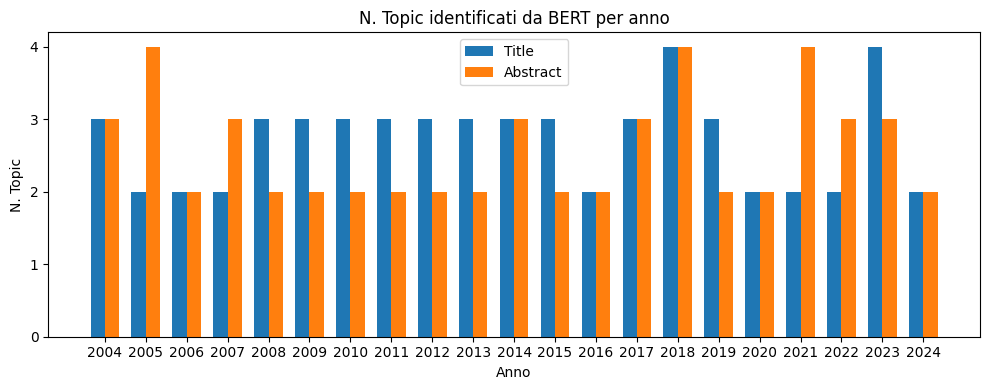

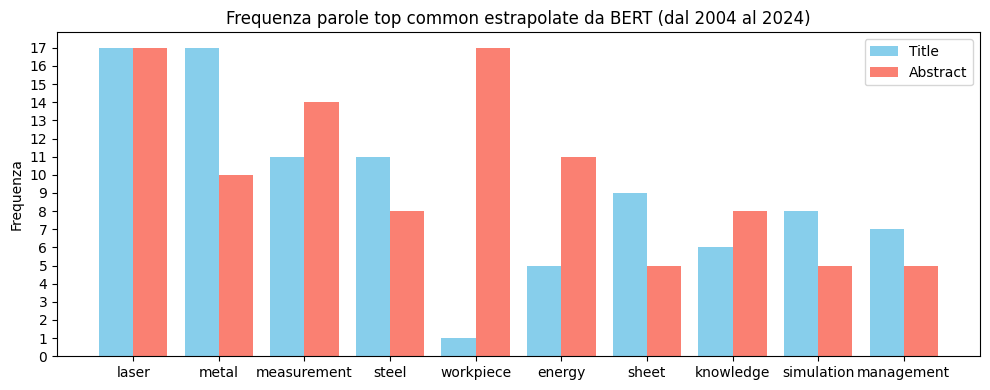

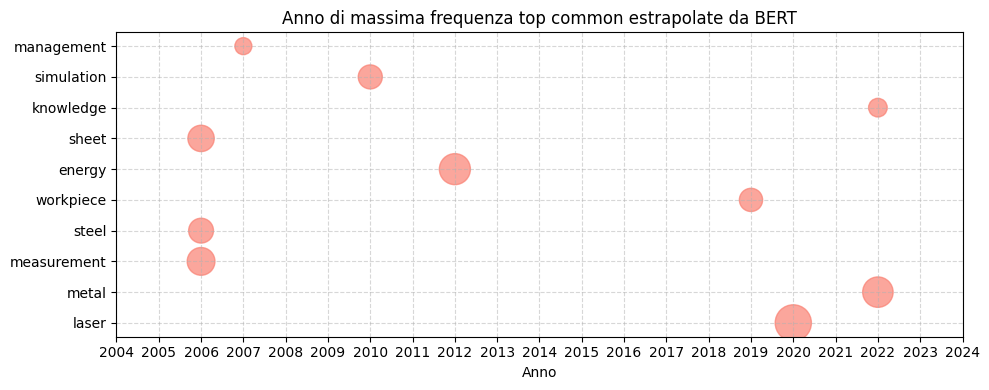

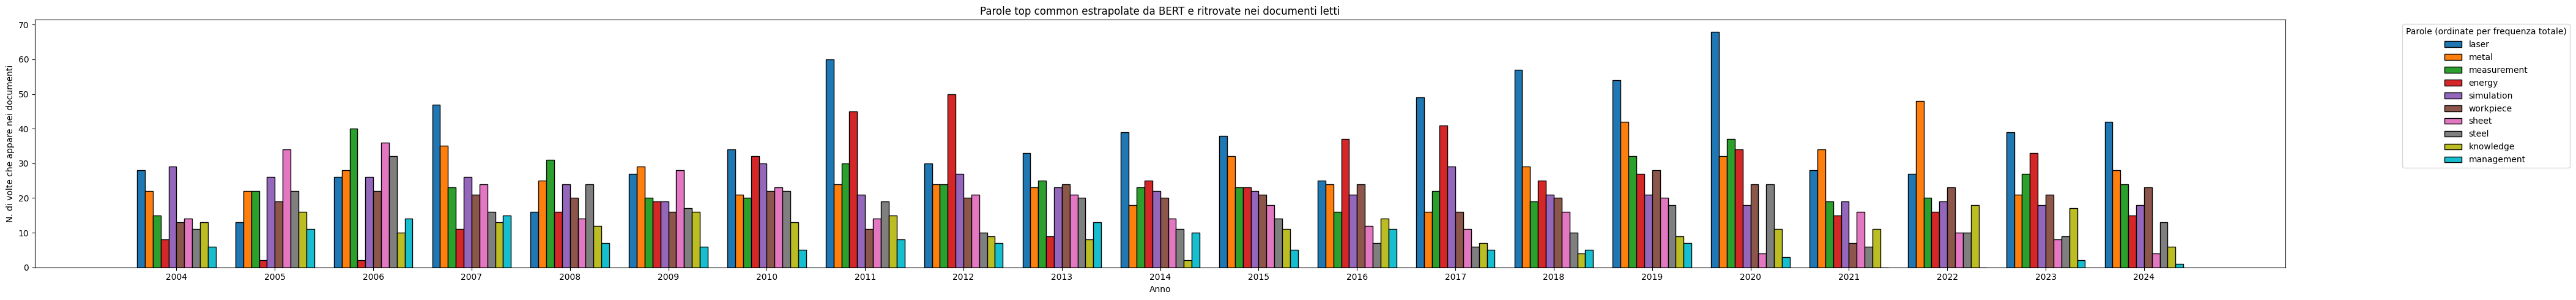

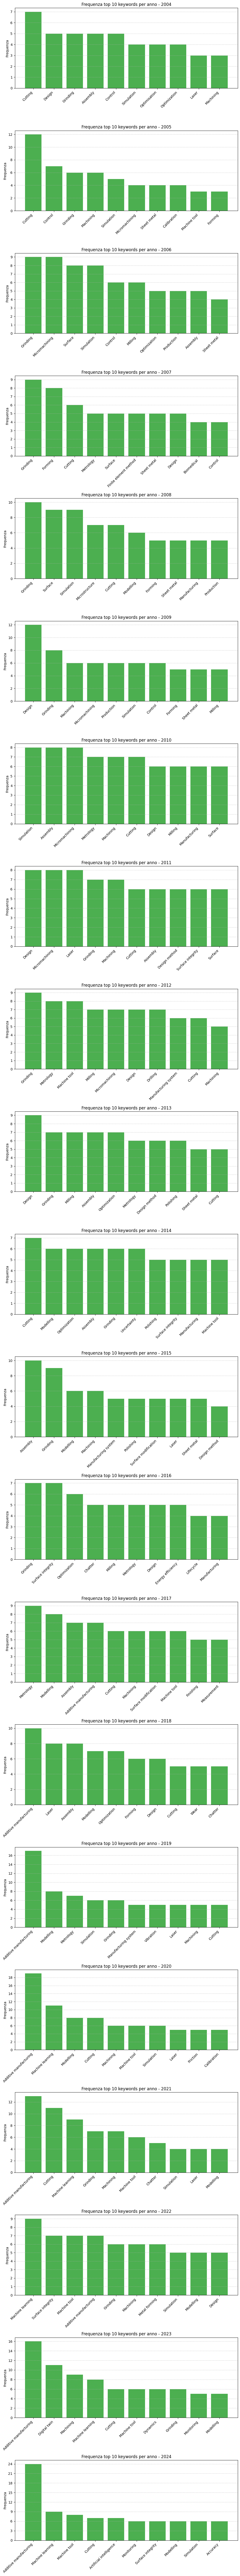

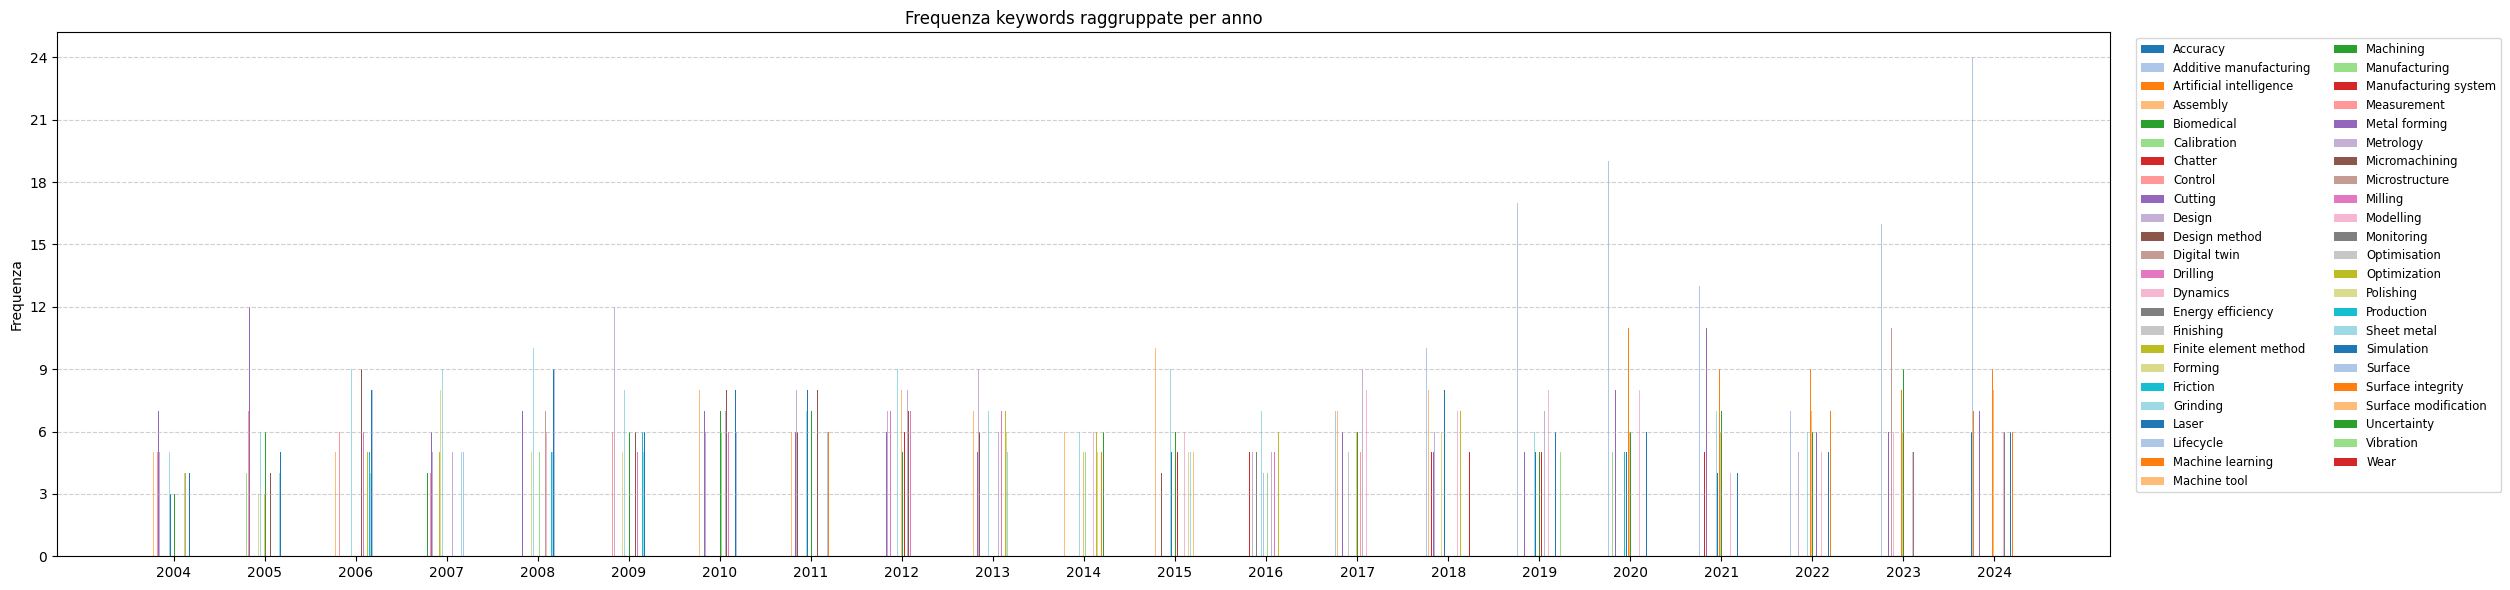

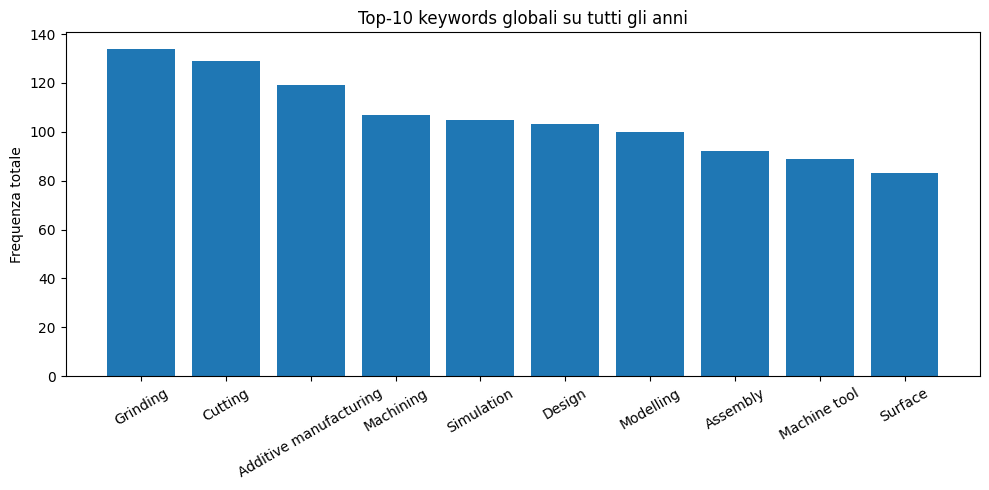

In [4]:
# === STEP 4
# === Analisi dati sulla base dei dati allenati da BERT

# Analisi 1
# N. Topic identificati da BERT per anno

years = sorted(bert_arguments.keys())
title_counts = [len(bert_arguments[year]["title"]["topic"]) for year in years]
abstract_counts = [len(bert_arguments[year]["abstract"]["topic"]) for year in years]

x = range(len(years))
width = 0.35

plt.figure(figsize=(10, 4))
plt.bar([i - width/2 for i in x], title_counts, width=width, label="Title")
plt.bar([i + width/2 for i in x], abstract_counts, width=width, label="Abstract")
plt.xticks(x, years)
plt.xlabel("Anno")
plt.ylabel("N. Topic")
plt.title("N. Topic identificati da BERT per anno")
plt.legend()
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


# Analisi 2
# Frequenza delle parole estrapolate da BERT

title_words = estrai_parole(bert_arguments, "title")
abstract_words = estrai_parole(bert_arguments, "abstract")
title_freq = Counter(title_words)
abstract_freq = Counter(abstract_words)
common_words = set(title_freq.keys()) & set(abstract_freq.keys())

# Top 10 parole comuni più frequenti (somma delle frequenze)
top_common = sorted(
    common_words,
    key=lambda w: title_freq[w] + abstract_freq[w],
    reverse=True
)[:10]

title_counts = [title_freq[word] for word in top_common]
abstract_counts = [abstract_freq[word] for word in top_common]

x = range(len(top_common))
plt.figure(figsize=(10, 4))
plt.bar(x, title_counts, width=0.4, label='Title', align='center', color='skyblue')
plt.bar([i + 0.4 for i in x], abstract_counts, width=0.4, label='Abstract', align='center', color='salmon')
plt.xticks([i + 0.2 for i in x], top_common)
plt.ylabel("Frequenza")
plt.title(f"Frequenza parole top common estrapolate da BERT (dal {year_from} al {year_to})")
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yticks(range(0, max(title_counts + abstract_counts) + 1))
plt.tight_layout()
plt.show()


# Analisi 3
# Ricercare all'interno dei files la frequenza delle parole top_common
# Anno di massima frequenza delle parole top common estrapolate da BERT

word_frequency = {}
for year in range_years:
    dict_frequency = {}
    filepath = os.path.join(folder_path, f'{year}.txt')
    if not os.path.isfile(filepath):
        for word in top_common:
            dict_frequency[word] = 0
        word_frequency[year] = dict_frequency
        continue

    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read().lower().split()
    for word in top_common:
        dict_frequency[word] = text.count(word.lower())
    word_frequency[year] = dict_frequency

parola_to_anno = {}
for anno, parole in word_frequency.items():
    for parola, count in parole.items():
        parola_to_anno.setdefault(parola, {})[anno] = count

massimo_per_parola = {}
for parola, anni in parola_to_anno.items():
    if all(count == 0 for count in anni.values()):
        massimo_per_parola[parola] = None
    else:
        massimo_per_parola[parola] = max(anni.items(), key=lambda x: x[1])[0]

plot_years = []
plot_yidx = []
plot_sizes = []

for parola in top_common:
    anno = massimo_per_parola.get(parola)
    if anno is None:
        continue
    count = parola_to_anno[parola][anno]
    plot_years.append(int(anno))
    plot_yidx.append(top_common.index(parola))
    plot_sizes.append(max(20, count * 10))

if len(plot_years) > 0:
    plt.figure(figsize=(10, 4))
    plt.scatter(plot_years, plot_yidx, s=plot_sizes, alpha=0.7, color="salmon")
    plt.yticks(range(len(top_common)), top_common)
    plt.xlabel("Anno")
    plt.title("Anno di massima frequenza top common estrapolate da BERT")
    plt.grid(True, linestyle="--", alpha=0.5)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(range_years)
    plt.tight_layout()
    plt.show()
else:
    print("[INFO]: Nessuna delle parole top_common è stata trovata in alcun file.\n")


# Numero di volte in cui le parole sono state trovate nei documenti
word_frequency = {}
for year in range_years:
    dict_frequency = {}
    for word in top_common:
        with open(os.path.join(folder_path, f'{year}.txt'), 'r', encoding='utf-8') as f:
            lines = f.readlines()
            count = 0
            for line in lines:
                count += line.lower().split().count(word.lower())

            dict_frequency[word] = count
    word_frequency[year] = dict_frequency


# Grafico per anno delle parole top common
years = sorted(word_frequency.keys())
words = list(next(iter(word_frequency.values())).keys())
total_freq = {word: sum(word_frequency[y][word] for y in years) for word in words}
sorted_words = sorted(total_freq.keys(), key=lambda w: total_freq[w], reverse=True)
freq_matrix = np.array([[word_frequency[y][w] for w in sorted_words] for y in years])

num_years = len(years)
num_words = len(sorted_words)
group_width = 0.8
bar_width = group_width / num_words

x = np.arange(num_years)
plt.figure(figsize=(max(10, num_years * 2), 5))

for i, word in enumerate(sorted_words):
    plt.bar(
        x + i * bar_width - (group_width - bar_width) / 2,
        freq_matrix[:, i],
        width=bar_width,
        label=word,
        edgecolor='black'
    )

plt.xticks(x, years)
plt.xlabel("Anno")
plt.ylabel("N. di volte che appare nei documenti")
plt.title("Parole top common estrapolate da BERT e ritrovate nei documenti letti")
plt.legend(title="Parole (ordinate per frequenza totale)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Grafico per le keywords
keywords_dict = {}
for year in bert_arguments.keys():
    keywords_dict[year] = list(bert_arguments[year]['keywords'])

num_years = len(keywords_dict)
plt.figure(figsize=(10, 5 * num_years))

for i, (year, keywords_list) in enumerate(sorted(keywords_dict.items()), start=1):
    counter = Counter(keywords_list)
    top_10 = counter.most_common(10)
    words = [item[0] for item in top_10]
    counts = [item[1] for item in top_10]

    plt.subplot(num_years, 1, i)
    plt.bar(words, counts, color="#4CAF50")
    plt.title(f"Frequenza top 10 keywords per anno - {year}")
    plt.ylabel("Frequenza")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


# Riepilogo di parole BERT per tutti gli anni
top_n = 10

year_top = {}
all_words = set()
for year, keywords_list in keywords_dict.items():
    c = Counter(keywords_list)
    top = [w for w,_ in c.most_common(top_n)]
    year_top[year] = {w: c.get(w, 0) for w in top}
    all_words.update(top)

all_words = sorted(all_words)
years = sorted(year_top.keys())

counts = np.zeros((len(all_words), len(years)), dtype=int)
word_to_idx = {w:i for i,w in enumerate(all_words)}
for j, y in enumerate(years):
    for w, cnt in year_top[y].items():
        counts[word_to_idx[w], j] = cnt

n_words = len(all_words)
n_years = len(years)

group_width = 0.8
bar_width = group_width / n_words
gap = 0.6  # spazio tra i gruppi degli anni

positions = []
for j in range(n_years):
    group_center = j * (1 + gap)
    starts = [group_center - group_width/2 + k*bar_width for k in range(n_words)]
    positions.append(starts)

plt.figure(figsize=(max(10, n_years*1.2), 6))

cmap = plt.get_cmap("tab20")
colors = [cmap(i % cmap.N) for i in range(n_words)]

for i, w in enumerate(all_words):
    xpos = [positions[j][i] for j in range(n_years)]
    plt.bar(xpos, counts[i], width=bar_width, label=w, color=colors[i])

xticks = [j*(1+gap) for j in range(n_years)]
plt.xticks(xticks, [str(y) for y in years])
plt.ylabel("Frequenza")
plt.title("Frequenza keywords raggruppate per anno")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(ncol=2, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


# Top 10 keywords tra tutti gli anni
global_c = Counter()
for year, kw_list in keywords_dict.items():
    global_c.update(kw_list)

top10 = global_c.most_common(10)
words = [w for w,_ in top10]
freqs = [f for _,f in top10]

plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.ylabel("Frequenza totale")
plt.title("Top-10 keywords globali su tutti gli anni")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Print riepilogative
if print_debug:
    for year in word_frequency:
        for word, count in word_frequency[year].items():
            print(f"Anno {year}: la parola '{word}' appare {count} volte")

    for parola, anno in massimo_per_parola.items():
        if anno is None:
            print(f"La parola '{parola}' non è stata trovata in nessun documento")
        else:
            print(f"La parola '{parola}' appare più spesso nel {anno}")

In [5]:
# STEP 5: Validazione del modello

# Converti i record in liste di parole
tokenized_records = []
for rec in records:
    text = (rec.get("title", "") + " " + rec.get("abstract", "")).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokenized_records.append(tokens)

id2word = corpora.Dictionary(tokenized_records)

topics = []
for topic_id in topic_model1.get_topic_info()['Topic']:
    if topic_id == -1:
        continue
    topic = topic_model1.get_topic(topic_id)
    topic_words = [word for word, _ in topic]
    topics.append(topic_words)

cm = CoherenceModel(topics=topics, texts=tokenized_records, dictionary=id2word, coherence='c_v')
coherence_score = cm.get_coherence()
print("Coherence:", round(coherence_score, 3))

all_words = [word for topic in topics for word in topic]
diversity = len(set(all_words)) / len(all_words)
print("Topic Diversity:", round(diversity, 3))

Coherence: 0.356
Topic Diversity: 1.0
